<a href="https://colab.research.google.com/github/FirangizSadiyeva/Covid-19/blob/main/Covid-19_predictionRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
# -*- coding: utf-8 -*-
"""
Created on January 2021
@author: FS
"""
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
import configparser
from datetime import timedelta
from statsmodels.tsa.api import Holt
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

In [132]:
corona_confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
corona_deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
corona_recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
#corona_confirmed_df.head()

In [133]:
corona_confirmed_df=corona_confirmed_df.melt(id_vars=['Province/State','Country/Region','Lat','Long'])
corona_confirmed_df=corona_confirmed_df.rename({'variable':'Date','value':'confirmed'}, axis='columns')

In [134]:
corona_deaths_df=corona_deaths_df.melt(id_vars=['Province/State','Country/Region','Lat','Long'])
corona_deaths_df=corona_deaths_df.rename({'variable':'Date','value':'deaths'}, axis='columns')

In [135]:
corona_recovered_df=corona_recovered_df.melt(id_vars=['Province/State','Country/Region','Lat','Long'])
corona_recovered_df=corona_recovered_df.rename({'variable':'Date','value':'recovered'}, axis='columns')

In [136]:
combined_df = [corona_confirmed_df, corona_deaths_df, corona_recovered_df]
combined_df = [df.set_index(['Province/State','Country/Region','Lat','Long','Date']) for df in combined_df]
combined_df=combined_df[0].join(combined_df[1:])

In [137]:
combined_df=combined_df.reset_index()

In [138]:
combined_df[['Date']] = combined_df[['Date']].apply(pd.to_datetime)
combined_df[['confirmed']] = combined_df[['confirmed']].apply(np.int64)
combined_df[['deaths']] = combined_df[['deaths']].apply(np.int64)
combined_df[['recovered']] = combined_df[['recovered']].apply(np.int64)

In [139]:
combined_df=combined_df.rename({'Province/State':'State','Country/Region':'Country'}, axis ='columns')

In [140]:
combined_df.drop(["State"],1,inplace=True)
combined_df.drop(["Lat"],1,inplace=True)
combined_df.drop(["Long"],1,inplace=True)

In [141]:
print("Size/Shape of the dataset",combined_df.shape)
print("Checking for null values",combined_df.isnull().sum())
print("Checking Data-type", combined_df.dtypes)

Size/Shape of the dataset (101010, 5)
Checking for null values Country      0
Date         0
confirmed    0
deaths       0
recovered    0
dtype: int64
Checking Data-type Country              object
Date         datetime64[ns]
confirmed             int64
deaths                int64
recovered             int64
dtype: object


In [142]:
combined_df.isnull().sum()

Country      0
Date         0
confirmed    0
deaths       0
recovered    0
dtype: int64

In [143]:
def pltCountry_cases_1(confirmed,*argv):
    f, ax=plt.subplots(figsize=(16,5))
    labels=argv
    for a in argv: 
        country=combined_df.loc[(combined_df['Country']==a)]
        plt.plot(country['Date'],country['confirmed'],linewidth=3)
        plt.xticks(rotation=40)
        plt.legend(labels)
        ax.set(title='Evolution of the number of confirmed_cases' )

In [144]:

def pltCountry_cases_2(recovered,*argv):
    f, ax=plt.subplots(figsize=(16,5))
    labels=argv
    for a in argv: 
        country=combined_df.loc[(combined_df['Country']==a)]
        plt.plot(country['Date'],country['recovered'],linewidth=3)
        plt.xticks(rotation=40)
        plt.legend(labels)
        ax.set(title='Evolution of the number of recovered_cases' )

In [145]:
def pltCountry_cases_3(deaths,*argv):
    f, ax=plt.subplots(figsize=(16,5))
    labels=argv
    for a in argv: 
        country=combined_df.loc[(combined_df['Country']==a)]
        plt.plot(country['Date'],country['deaths'],linewidth=3)
        plt.xticks(rotation=40)
        plt.legend(labels)
        ax.set(title='Evolution of the number of deaths_cases' )

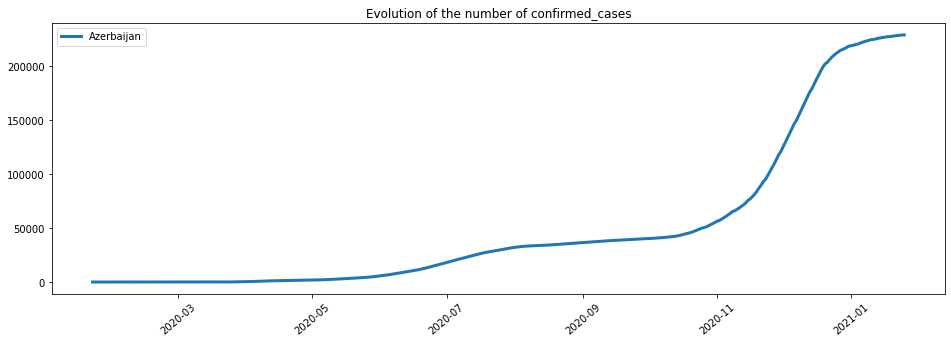

In [146]:
pltCountry_cases_1('confirmed','Azerbaijan')

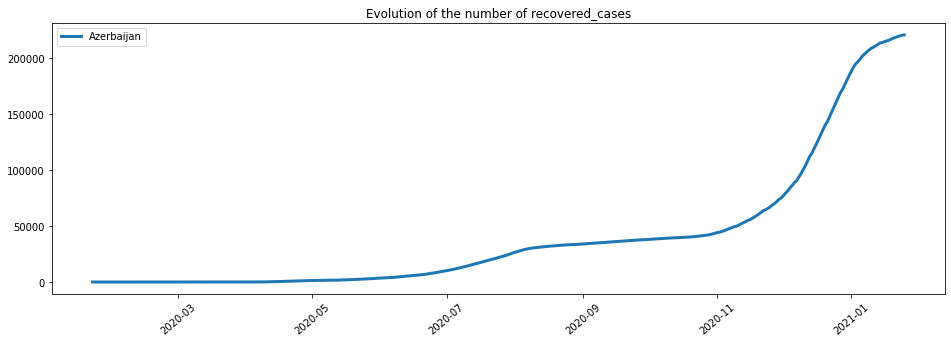

In [147]:
pltCountry_cases_2('recovered','Azerbaijan')

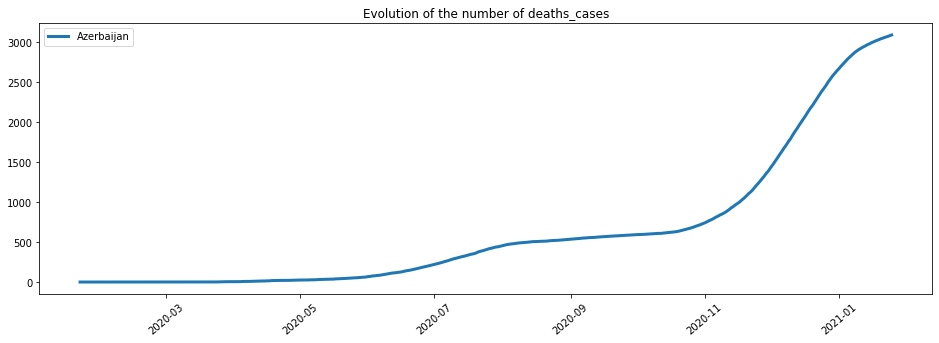

In [148]:
pltCountry_cases_3('deaths','Azerbaijan')

For Azerbaijan

In [149]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [150]:
combined_df= combined_df[combined_df['Country']=='Azerbaijan']
combined_df

,Country,Date,confirmed,deaths,recovered
17,Azerbaijan,2020-01-22,0,0,0
290,Azerbaijan,2020-01-23,0,0,0
563,Azerbaijan,2020-01-24,0,0,0
836,Azerbaijan,2020-01-25,0,0,0
1109,Azerbaijan,2020-01-26,0,0,0
...,...,...,...,...,...
99662,Azerbaijan,2021-01-21,228246,3053,218387
99935,Azerbaijan,2021-01-22,228526,3064,219019
100208,Azerbaijan,2021-01-23,228688,3072,219724
100481,Azerbaijan,2021-01-24,228975,3082,220292


In [151]:
combined_df.drop(["Country"],1,inplace=True)
combined_df

,Date,confirmed,deaths,recovered
17,2020-01-22,0,0,0
290,2020-01-23,0,0,0
563,2020-01-24,0,0,0
836,2020-01-25,0,0,0
1109,2020-01-26,0,0,0
...,...,...,...,...
99662,2021-01-21,228246,3053,218387
99935,2021-01-22,228526,3064,219019
100208,2021-01-23,228688,3072,219724
100481,2021-01-24,228975,3082,220292


In [152]:
# Importing the training set
from sklearn.model_selection import train_test_split
train, test = train_test_split(combined_df, test_size=0.2, random_state=42, shuffle=True)

In [153]:
train

,Date,confirmed,deaths,recovered
94202,2021-01-01,219041,2670,188280
52433,2020-08-01,32157,454,26474
20492,2020-04-06,641,7,44
22949,2020-04-15,1253,13,404
97751,2021-01-14,226200,2971,213279
...,...,...,...,...
19400,2020-04-02,400,5,26
28955,2020-05-07,2204,28,1551
73727,2020-10-18,44964,626,40037
95021,2021-01-04,220599,2761,196734


In [154]:
test

,Date,confirmed,deaths,recovered
89288,2020-12-14,178986,1966,114841
9026,2020-02-24,0,0,0
4112,2020-02-06,0,0,0
85739,2020-12-01,125602,1433,76897
15578,2020-03-19,44,1,6
...,...,...,...,...
22403,2020-04-13,1148,12,289
25679,2020-04-25,1617,21,1080
53252,2020-08-04,32910,473,28348
84920,2020-11-28,114025,1323,71691


In [155]:
training_set = train.iloc[:, 1:2].values
training_set

array([[219041],
       [ 32157],
       [   641],
       [  1253],
       [226200],
       [     0],
       [   182],
       [ 55269],
       [     0],
       [  2879],
       [  3274],
       [183259],
       [162774],
       [ 47418],
       [ 19267],
       [  2589],
       [228975],
       [    65],
       [ 15890],
       [154152],
       [ 36435],
       [ 37192],
       [  8882],
       [     0],
       [ 39686],
       [     0],
       [ 33731],
       [171423],
       [227273],
       [ 40931],
       [  8530],
       [220265],
       [ 38172],
       [228246],
       [ 81397],
       [202088],
       [ 45295],
       [ 24041],
       [ 33103],
       [     0],
       [224651],
       [   991],
       [ 21374],
       [     0],
       [ 33376],
       [  2060],
       [ 57040],
       [  3518],
       [222200],
       [     0],
       [     0],
       [ 16424],
       [ 28980],
       [ 21916],
       [ 83994],
       [  8191],
       [208211],
       [ 25672],
       [    53

In [156]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [157]:
# Creating a data structure
X_train = []
y_train = []
for i in range(80, 290):
    X_train.append(training_set_scaled[i-80:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [158]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [159]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [160]:
# Initialising the RNN
regressor = Sequential()

In [161]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 45, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

In [162]:
# Adding a second LSTM layer nd some Dropout regularisation
regressor.add(LSTM(units = 45, return_sequences = True))
regressor.add(Dropout(0.2))

In [163]:
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 45, return_sequences = True))
regressor.add(Dropout(0.2))

In [164]:
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 45))
regressor.add(Dropout(0.2))

In [165]:
# Adding the output layer
regressor.add(Dense(units = 1))

In [166]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [167]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 80 , batch_size = 32)

Epoch 1/80
7/7 [==============================] - 7s 130ms/step - loss: 0.1023
Epoch 2/80
7/7 [==============================] - 1s 143ms/step - loss: 0.0855
Epoch 3/80
7/7 [==============================] - 1s 141ms/step - loss: 0.0940
Epoch 4/80
7/7 [==============================] - 1s 140ms/step - loss: 0.0838
Epoch 5/80
7/7 [==============================] - 1s 136ms/step - loss: 0.0802
Epoch 6/80
7/7 [==============================] - 1s 136ms/step - loss: 0.0785
Epoch 7/80
7/7 [==============================] - 1s 143ms/step - loss: 0.0815
Epoch 8/80
7/7 [==============================] - 1s 138ms/step - loss: 0.0846
Epoch 9/80
7/7 [==============================] - 1s 149ms/step - loss: 0.0839
Epoch 10/80
7/7 [==============================] - 1s 139ms/step - loss: 0.0940
Epoch 11/80
7/7 [==============================] - 1s 136ms/step - loss: 0.0744
Epoch 12/80
7/7 [==============================] - 1s 140ms/step - loss: 0.0931
Epoch 13/80
7/7 [==============================] 

In [168]:
# Part 3 - Making the predictions 

# Getting the real data
real_confirmed_rate = test.iloc[:, 4:5].values

In [179]:
# Getting the predicted data
dataset_total = pd.concat((train['confirmed'], test['confirmed']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 80:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(80, 154):
    X_test.append(inputs[i-80:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_confirmed_rate = regressor.predict(X_test)
predicted_confirmed_rate = sc.inverse_transform(predicted_confirmed_rate)

In [180]:
train.to_csv(r'Az1.csv')
test.to_csv(r'Az2.csv')

In [182]:
# Part 4 - Visualising the results

# Making structure for visualising

df_old = pd.read_csv('Az1.csv', usecols = ['Date', 'confirmed'])
df_pred = pd.read_csv('Az2.csv', usecols = ['Date'])
df_pred['confirmed'] = predicted_confirmed_rate
frames = [df_old, df_pred]
df_result = pd.concat(frames)

copy = df_result
copy = copy.drop('Date', axis=1)
copy_df_date = df_result
copy_df_date = copy_df_date.drop('confirmed', axis=1)

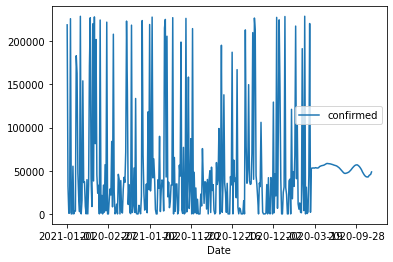

In [183]:
# Visualizing predicted Data
datelist2 = list(copy_df_date.iloc[:, 0].values)
copy['Date'] = datelist2 
copy = copy.set_index(['Date'])
copy.plot()

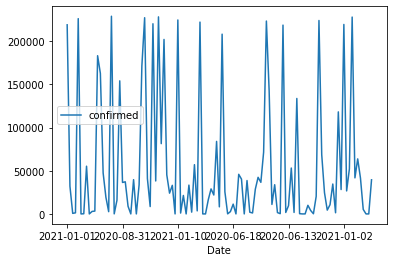

In [185]:
dates = list(test.iloc[:, 0].values)
df_3 = pd.DataFrame(predicted_confirmed_rate)
df_4 = dates
df_3['Date'] = df_4
df_3 = df_3.set_index(['Date'])
df_54 = copy[:111].copy(deep = True)
df_54.plot()

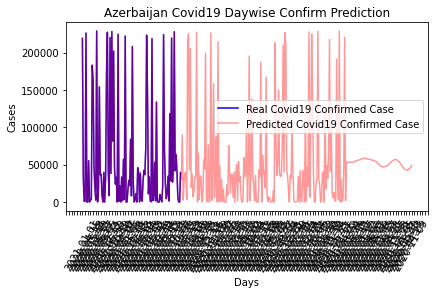

In [186]:
#visualization of future forecast/prediction
plt.plot(df_54, color = 'blue', label = 'Real Covid19 Confirmed Case')
plt.plot(copy, color = 'red', label = 'Predicted Covid19 Confirmed Case', alpha = 0.4)
plt.title('Azerbaijan Covid19 Daywise Confirm Prediction')
plt.xticks(rotation=60)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(3))
plt.tight_layout()
plt.xlabel('Days')
plt.ylabel('Cases')
plt.legend()
plt.show()